# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
!pip install ipython-autotime
!pip install alphalens

     |████████████████████████████████| 24.0 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 107 kB 46.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 42.7 MB/s eta 0:00:01     |██                              | 337 kB 42.7 MB/s eta 0:00:01
  Created wheel for alphalens: filename=alphalens-0.4.0-py3-none-any.whl size=24027558 sha256=ec2c8a6d8d41cb889f69d2b52570a65bf7966aae90cc9a8e554c8114def6120c
  Stored in directory: /home/jupyter/.cache/pip/wheels/10/a6/42/026fe89e82dbcde7f6f756465a10a045ada9902eb4592ce2d3
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39764 sha256=f79dd0d7c0a32cfa864cfd609e69f9d1344c98a36efac2fb9a6da6a6e75df380
  Stored in directory: /home/jupyter/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built alphalens empyrical


In [2]:
%matplotlib inline
%load_ext autotime

import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
idx = pd.IndexSlice

time: 1.97 s (started: 2021-05-02 06:11:14 +00:00)


In [3]:
### set path
import os
from pathlib import Path

path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'

time: 1.04 ms (started: 2021-05-02 06:11:16 +00:00)


In [5]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

Copying gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip...
| [1 files][401.4 MiB/401.4 MiB]                                                
Operation completed over 1 objects/401.4 MiB.                                    
Archive:  stooq_jp_data.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
  inflating: data/stooq_jp_equities.csv  
Copying gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip...
- [1 files][ 49.4 MiB/ 49.4 MiB]                                                
Operation completed over 1 objects/49.4 MiB.                                     
Archive:  stooq_jp_result.zip
  inflating: result/lin_reg_performance.csv  
  inflating: result/test_01.csv      
  inflating: result/daily_ic_avg.csv  
  inflating: result/prediction_01.csv  
time: 27.4 s (started: 2021-05-02 06:11:59 +00:00)


## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

time: 474 µs (started: 2021-05-02 06:13:07 +00:00)


### Get AlphaLens Input

Using next available prices.

In [7]:
def get_trade_prices(tickers):
    prices = (pd.read_csv(path_data / 'stooq_jp_tse_stocks_prices.csv', parse_dates=['date'])
                .set_index(['ticker','date'])
                .sort_index(level=['ticker','date']))
    return (prices.loc[idx[tickers, '2015': '2019'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

time: 746 µs (started: 2021-05-02 06:13:09 +00:00)


Reloading predictions.

In [8]:
best_predictions = (pd.read_csv(path_result / f'test_{lookahead:02}.csv', parse_dates=['date'])
                      .set_index(['ticker','date'])
                      .sort_index(level=['ticker','date'])
                      .drop('y_test', axis=1))            
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2016-12-14 00:00:00')) to ('9990.JP', Timestamp('2018-12-28 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       474264 non-null  float64
 1   1       474264 non-null  float64
 2   2       474264 non-null  float64
 3   3       474264 non-null  float64
 4   4       474264 non-null  float64
 5   5       474264 non-null  float64
 6   6       474264 non-null  float64
 7   7       474264 non-null  float64
 8   8       474264 non-null  float64
 9   9       474264 non-null  float64
dtypes: float64(10)
memory usage: 38.1+ MB
time: 1.44 s (started: 2021-05-02 06:13:12 +00:00)


In [9]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1220 entries, 2015-01-05 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 8.8 MB
time: 3min 6s (started: 2021-05-02 06:13:18 +00:00)


In [10]:
factor = (best_predictions
          #.loc[idx[:, :'2017'], ['0']] # in-sample
          .loc[idx[:, :'2017'], :].mean(1) # in-sample
          .tz_localize('UTC', level='date')
          .swaplevel()
          .dropna()
          .reset_index()
          .drop_duplicates()
          .set_index(['date', 'ticker']))

factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 243719 entries, (Timestamp('2016-12-14 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2017-12-29 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               243719 non-null  float64
 1   5D               243719 non-null  float64
 2   10D              243719 non-null  float64
 3   21D              243719 non-null  float64
 4   factor           243719 non-null  float64
 5   factor_quantile  243719 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 12.1+ MB
time: 4.59 s (started: 2021-05-02 06:16:24 +00:00)


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.011432,0.004447,-0.000920,0.002919,49003,20.106352
2,-0.010994,0.005414,-0.000359,0.002914,48660,19.965616
3,-0.010618,0.006576,0.000062,0.002884,48694,19.979567
4,-0.010197,0.007972,0.000513,0.002860,48678,19.973002
5,-0.010164,0.022209,0.001476,0.003133,48684,19.975464


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.039,-0.002,-0.006,0.010
beta,0.014,0.040,0.081,0.034
Mean Period Wise Return Top Quantile (bps),2.486,0.745,1.071,1.311
Mean Period Wise Return Bottom Quantile (bps),-0.994,-0.151,-0.450,-0.669
Mean Period Wise Spread (bps),3.480,0.896,1.523,1.979


Information Analysis


,1D,5D,10D,21D
IC Mean,0.005,0.002,0.008,0.022
IC Std.,0.104,0.088,0.089,0.080
Risk-Adjusted IC,0.048,0.025,0.085,0.270
t-stat(IC),0.767,0.407,1.368,4.344
p-value(IC),0.444,0.684,0.172,0.000
IC Skew,0.188,0.205,0.108,0.256
IC Kurtosis,1.609,1.100,1.390,1.091


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.697,0.716,0.778,0.800
Quantile 2 Mean Turnover,0.752,0.762,0.784,0.800
Quantile 3 Mean Turnover,0.766,0.776,0.794,0.797
Quantile 4 Mean Turnover,0.748,0.767,0.788,0.801
Quantile 5 Mean Turnover,0.637,0.688,0.747,0.786


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.241,0.2,0.076,0.003


<Figure size 432x288 with 0 Axes>

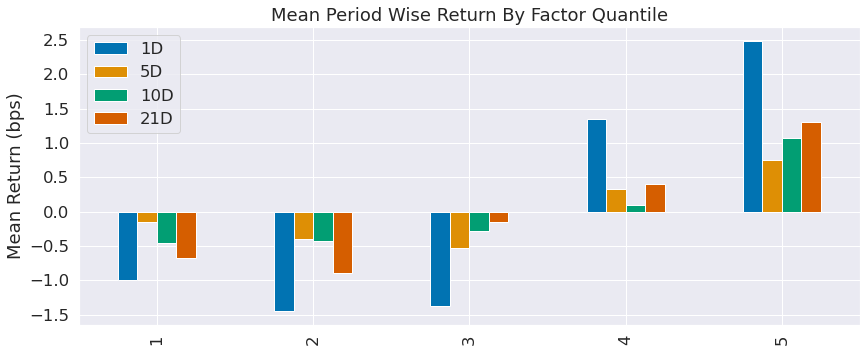

time: 10.8 s (started: 2021-05-02 06:16:37 +00:00)


In [11]:
create_summary_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [12]:
t = 1
predictions = (pd.read_csv(path_result / f'test_{t:02}.csv', parse_dates=['date'])
                 .set_index(['ticker','date'])
                 .sort_index(level=['ticker','date'])   
                 .drop('y_test', axis=1))
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2016-12-14 00:00:00')) to ('9990.JP', Timestamp('2018-12-28 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       474264 non-null  float64
 1   1       474264 non-null  float64
 2   2       474264 non-null  float64
 3   3       474264 non-null  float64
 4   4       474264 non-null  float64
 5   5       474264 non-null  float64
 6   6       474264 non-null  float64
 7   7       474264 non-null  float64
 8   8       474264 non-null  float64
 9   9       474264 non-null  float64
dtypes: float64(10)
memory usage: 38.1+ MB
time: 1.34 s (started: 2021-05-02 06:16:58 +00:00)


In [13]:
factor = (predictions.loc[idx[:,'2018'], :]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker 
2018-01-04 00:00:00+00:00  1332.JP   -0.002073
2018-01-05 00:00:00+00:00  1332.JP    0.000645
2018-01-09 00:00:00+00:00  1332.JP   -0.000411
2018-01-10 00:00:00+00:00  1332.JP    0.001646
2018-01-11 00:00:00+00:00  1332.JP   -0.000931
dtype: float64

time: 118 ms (started: 2021-05-02 06:16:59 +00:00)


### Select next available trade prices

Using next available prices.

In [14]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1220 entries, 2015-01-05 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 8.8 MB
time: 3min 11s (started: 2021-05-02 06:17:02 +00:00)


### Get AlphaLens Inputs

In [15]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 230545 entries, (Timestamp('2018-01-04 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2018-12-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               230545 non-null  float64
 1   5D               230545 non-null  float64
 2   10D              230545 non-null  float64
 3   21D              230545 non-null  float64
 4   factor           230545 non-null  float64
 5   factor_quantile  230545 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 11.5+ MB
time: 4.39 s (started: 2021-05-02 06:20:14 +00:00)


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.036597,0.007507,-0.003023,0.004730,46310,20.087185
2,-0.025832,0.008919,-0.001993,0.004050,46059,19.978312
3,-0.021078,0.009497,-0.001266,0.003579,46060,19.978746
4,-0.016346,0.009945,-0.000672,0.003293,46058,19.977879
5,-0.013150,0.011988,0.000242,0.003129,46058,19.977879


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.090,0.022,0.006,0.005
beta,0.059,0.038,0.046,0.051
Mean Period Wise Return Top Quantile (bps),4.568,0.305,-0.348,-0.501
Mean Period Wise Return Bottom Quantile (bps),-3.584,-0.459,-0.102,-0.290
Mean Period Wise Spread (bps),8.152,0.764,-0.250,-0.217


Information Analysis


,1D,5D,10D,21D
IC Mean,0.016,0.007,-0.002,-0.003
IC Std.,0.103,0.108,0.097,0.097
Risk-Adjusted IC,0.152,0.069,-0.019,-0.028
t-stat(IC),2.379,1.074,-0.298,-0.434
p-value(IC),0.018,0.284,0.766,0.665
IC Skew,0.050,0.219,0.333,0.333
IC Kurtosis,0.865,0.731,1.644,1.101


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.735,0.769,0.791,0.796
Quantile 2 Mean Turnover,0.773,0.787,0.792,0.797
Quantile 3 Mean Turnover,0.775,0.790,0.795,0.795
Quantile 4 Mean Turnover,0.772,0.791,0.799,0.795
Quantile 5 Mean Turnover,0.681,0.740,0.776,0.792


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.15,0.076,0.016,0.006


<Figure size 432x288 with 0 Axes>

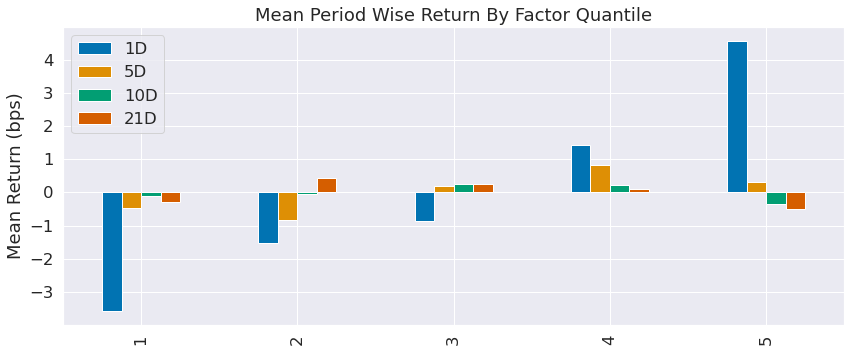

time: 11.1 s (started: 2021-05-02 06:20:18 +00:00)


In [16]:
create_summary_tear_sheet(factor_data)